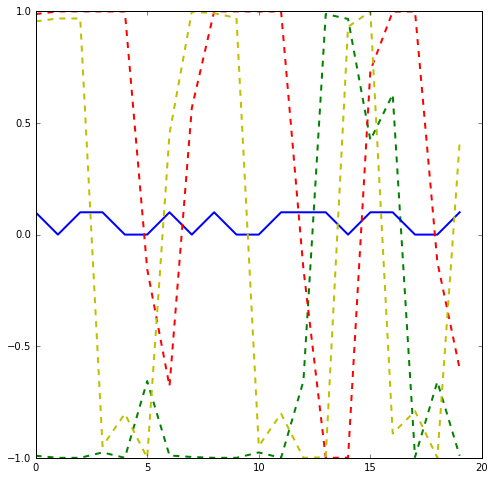

In [5]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import getData

from easydict import EasyDict as edict
args = edict({'hidden_size':3, 'batch_size':1, 'output_size': 2, 'seq_len': 20, 'train_method': "single", 'max_grad_norm':5.0, 'grad_clip': True})

hidden_size = args.hidden_size # 2 # 4
batch_size = args.batch_size #1
output_size = args.output_size  #2
seq_len = args.seq_len  #12 #3  #6 

g1 = tf.Graph()

with g1.as_default(): 
    ############## Graph construction ################
    data = tf.placeholder(tf.float32, shape=[batch_size, seq_len])
    if args.train_method == "single":
        target = tf.placeholder(tf.float32, shape=[batch_size, output_size])
    else:
        target = tf.placeholder(tf.float32, shape=[seq_len, batch_size, output_size])
        target_list = [tf.squeeze(tf.slice(target, [i,0,0], [1, batch_size, output_size])) for i in range(seq_len)]
    learning_rate = tf.placeholder(tf.float32, shape=[])

    rnn_cell = tf.nn.rnn_cell.BasicRNNCell(hidden_size)
    # initialize the state
    initial_state = state = tf.zeros([batch_size, hidden_size])

    for i in range(seq_len):
        if i > 0: tf.get_variable_scope().reuse_variables()
        cell_output, state = rnn_cell(tf.reshape(data[:,i], [1,1]), state) # should change [1,1] if I want to change batch_size?
        state_name = 'state_' + str(i)
        tf.add_to_collection(state_name, state)
        # I need to use tf.get_variable to activate reuse_variables()
        weights = tf.get_variable("weights", dtype=tf.float32, initializer=tf.truncated_normal([hidden_size, output_size], stddev=1.0/math.sqrt(float(hidden_size))))
        biases = tf.get_variable("biases", dtype=tf.float32,initializer=tf.truncated_normal([output_size], stddev=1.0/math.sqrt(float(hidden_size))))
        output = tf.nn.softmax(tf.matmul(cell_output, weights) + biases) # the size of output should be just [batch_size, 1] right?
        if args.train_method == "single":                                                
            pass
        else:
            # target has to be shape=[seq_len * [1,2]]
            loss_per_digit = -tf.reduce_sum(target_list[i]*tf.log(output)) # this should be just 1 by 1 - 1 by 1            
            if args.grad_clip:
                tvars = tf.trainable_variables()
                grads, _ = tf.clip_by_global_norm(tf.gradients(loss_per_digit, tvars), args.max_grad_norm)
                optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
                train_op = optimizer.apply_gradients(zip(grads, tvars))
            else:
                train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

    if args.train_method == "single":
        #output = tf.Print(output, [output], message="this is output: ")
        #print(state)
        loss = -tf.reduce_sum(target*tf.log(output)) # this should be just 1 by 1 - 1 by 1
        tf.scalar_summary("loss", loss)
        #train_op = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
        if args.grad_clip:
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), args.max_grad_norm)
            #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            train_op = optimizer.apply_gradients(zip(grads, tvars))
        else:
            train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss) # 0.001
    else:
        loss = tf.identity(loss_per_digit)
    

    tf.add_to_collection('train_op', train_op)
    tf.add_to_collection('output', output)
    tf.add_to_collection('initial_state', initial_state)
    tf.add_to_collection('data', data)
    tf.add_to_collection('target', target)
    tf.add_to_collection('state', state)


    final_state = state

    summary_op = tf.merge_all_summaries()
    init_op = tf.initialize_all_variables()
    ############### Graph construction end ##########
    
    
# let's visualize the hidden state
with g1.as_default():
    saver_vis = tf.train.Saver(tf.all_variables())
    with tf.Session() as sess:
        saver_vis.restore(sess, './test-2016-07-12-18:07:14/my_model-0')
        
        
        state = tf.get_collection('state')[0]
        output = tf.get_collection('output')[0]
        
        x = getData.createInputData(seq_len)        
        x = np.float32(np.asarray(x).reshape(1, seq_len))
        y = getData.createTargetData(x[0])[-1]
        y_target = np.zeros((1,2))
        if y == 0: y_target[0][0] = 1
        else: y_target[0][1] = 1
        feed_dict={data:x}
        state_restore_np = np.zeros([seq_len, hidden_size])
        for i in range(seq_len):
            state_name = 'state_' + str(i)
            output_, state_restore_np[i] = sess.run([output, tf.get_collection(state_name)[0]], feed_dict=feed_dict)
            
%matplotlib inline
x_data = np.array(range(seq_len))
y_data2 = np.float32(getData.createTargetData(x[0])) * 0.1
y_data = state_restore_np[:, 0]
plt.figure(figsize=(8,8))
plot_out = plt.plot(x_data,y_data,'g--', x_data, y_data2, x_data, state_restore_np[:, 1], 'r--',x_data, state_restore_np[:, 2], 'y--', lw=2,alpha=1.0)
plt.show()

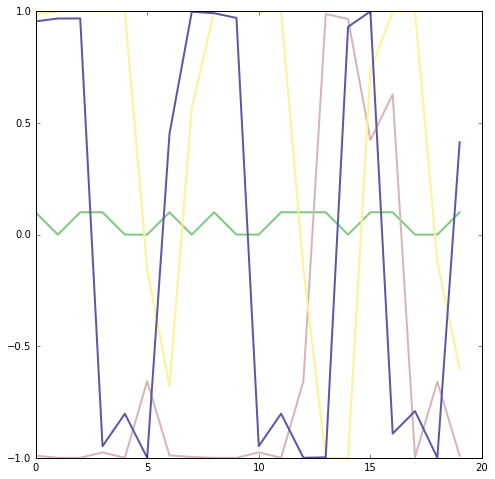

In [22]:
import matplotlib.cm as cm
%matplotlib inline
plt.figure(figsize=(8,8))
plt.hold(True);
x_data = np.array(range(seq_len))
y_data = np.zeros([hidden_size+1,seq_len])
for i in range(hidden_size+1):
    if i == 0: y_data[i] = np.float32(getData.createTargetData(x[0])) * 0.1
    else: y_data[i] = state_restore_np[:, i-1]
    c = cm.Accent(i/5.,1)
    plot_out = plt.plot(x_data, y_data[i], lw=2, color=c)
plt.show()